In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import timedelta
from matplotlib.ticker import MultipleLocator


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

from sklearn import model_selection, preprocessing, metrics, tree
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import make_scorer ,confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.svm import SVR



%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

seed_val = 42

/kaggle/dev/jovan/mercedes-benz-greener-manufacturing/venv-mercedes/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# constants
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data/'
SUBMISSION_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions'

In [3]:
# loading the data
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# reseting index
train = train.set_index('ID')
test = test.set_index('ID')

## Pre processing

In [4]:
# X0 groups
train['eng1_X0_group'] = train[['X0']].apply(lambda x: 0 if x['X0'] in ['bc', 'az']
                                       else 0 if x['X0']  in ['ac', 'am', 'l', 'b', 'aq', 'u', 'ad', 'e', 
                                                                 'al', 's', 'n', 'y', 't', 'ai', 'k', 'f', 'z', 
                                                                 'o', 'ba', 'm', 'q']
                                       else 2 if x['X0'] in ['d', 'ay', 'h', 'aj']
                                       else 3 if x['X0'] in ['v', 'ao', 'aw', 'c', 'ax', 'x', 'j', 'w', 'i',
                                                                'ak', 'g', 'at', 'ab', 'af', 'r', 'as', 'a', 'ap',
                                                                'au', 'aa']
                                       else 4, axis=1)

test['eng1_X0_group'] = test[['X0']].apply(lambda x: 0 if x['X0'] in ['bc', 'az']
                                       else 1 if x['X0']  in ['ac', 'am', 'l', 'b', 'aq', 'u', 'ad', 'e', 
                                                                 'al', 's', 'n', 'y', 't', 'ai', 'k', 'f', 'z', 
                                                                 'o', 'ba', 'm', 'q']
                                       else 2 if x['X0'] in ['d', 'ay', 'h', 'aj']
                                       else 3 if x['X0'] in ['v', 'ao', 'aw', 'c', 'ax', 'x', 'j', 'w', 'i',
                                                                'ak', 'g', 'at', 'ab', 'af', 'r', 'as', 'a', 'ap',
                                                                'au', 'aa']
                                       else 4, axis=1)



# #X5 groups
# train['X5_groups'] = train[['X5']].apply(lambda x: 'G0' if x['X5'] in ['h', 'x']
#                                          else 'G1' if x['X5'] in ['y', 'g', 'o'] 
#                                          else 'G2' if x['X5'] in ['aa', 'r', 'ah', 'w', 'k', 'ac', 'v', 'q', 'l',
#                                                                   'j', 'p', 'i', 'd', 'ae', 'ag', 's', 'n', 'm',
#                                                                   'af', 'ab', 'ad', 'c', 'f']
#                                          else 'G3' if x['X5'] in ['u']
#                                          else 'ERROR', axis=1)

# test['X5_groups'] = test[['X5']].apply(lambda x: 'G0' if x['X5'] in ['h', 'x']
#                                          else 'G1' if x['X5'] in ['y', 'g', 'o'] 
#                                          else 'G2' if x['X5'] in ['aa', 'r', 'ah', 'w', 'k', 'ac', 'v', 'q', 'l',
#                                                                   'j', 'p', 'i', 'd', 'ae', 'ag', 's', 'n', 'm',
#                                                                   'af', 'ab', 'ad', 'c', 'f']
#                                          else 'G3' if x['X5'] in ['u']
#                                          else 'ERROR', axis=1)

In [5]:
#X0_group version 2
train['eng1_X0_group_2'] = train[['X127', 'X118', 'X238']].apply(lambda x: 0 if(x['X127']==0 and x['X118']==0 and x['X238']==0)
                                                             else 1 if(x['X127']==1)
                                                             else 2 if(x['X127']==0 and x['X118']==0 and x['X238']==1)
                                                             else 3 if(x['X127']==0 and x['X118']==1)
                                                             else 4, axis=1)

test['eng1_X0_group_2'] = test[['X127', 'X118', 'X238']].apply(lambda x: 0 if(x['X127']==0 and x['X118']==0 and x['X238']==0)
                                                             else 1 if(x['X127']==1)
                                                             else 2 if(x['X127']==0 and x['X118']==0 and x['X238']==1)
                                                             else 3 if(x['X127']==0 and x['X118']==1)
                                                             else 4, axis=1)

In [6]:
train['eng1_bin_sum'] = train.iloc[:,9:377].apply(lambda x: np.sum(x), axis=1 )
test['eng1_bin_sum'] = test.iloc[:,8:376].apply(lambda x: np.sum(x), axis=1 )

### Data Cleaning

In [7]:
cols_drop = []
cols_drop.append(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']) # zero-var cols
cols_drop.append(['X5'])
for i, col in enumerate(cols_drop):
    train = train.drop(col, 1)
    test = test.drop(col, 1)

In [8]:
keep_cols = list(train.T.drop_duplicates().T.columns)
train = train[keep_cols]

keep_cols.remove('y')
test = test[keep_cols]

In [9]:
# keeping only values < 265 to remove the 1 outlier at y=265.32; ID=1770
train = train[train['y']<265]

### Splitting and Traning 

In [10]:
# train['pred1_group_y'] = train[['y']].apply(lambda x: 0 if (x['y']<80)
#                                            else 1 if (x['y']>80 and x['y']<96)
#                                            else 2 if (x['y']>96 and x['y']<103)
#                                            else 3 if (x['y']>103)
#                                            else -1, axis=1)

In [11]:
# target_col = ['pred1_group_y']
# ignore_cols = ['y']
# ignore_cols.append(target_col[0])
# train_cols = [col for col in train.columns if col not in ignore_cols]

# train_x = train[train_cols]
# train_y = train[target_col]
# test_x = test[train_cols]

In [12]:
# print('--- encoding columns from train and test datasets ---')
# for f in train_x.columns:
#     if train_x[f].dtype=='object':
#         print('encoding column:', f, '(original dtype:', train_x[f].dtype, ')')
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(set(train_x[f].values)| set(test_x[f].values))) 
#         train_x[f] = lbl.transform(list(train_x[f].values))
#         test_x[f] = lbl.transform(list(test_x[f].values))

In [13]:
# trn_x, val_x, trn_y, val_y = model_selection.train_test_split(train_x, train_y, test_size=0.20, random_state=42)
# print('trn_x.shape:', trn_x.shape)
# print('val_x.shape:', val_x.shape)
# print('trn_y.shape:', trn_y.shape)
# print('val_y.shape:', val_y.shape)
# trn_y = trn_y.values.ravel()
# val_y = val_y.values.ravel()

In [14]:
# def xgb_accuracy(y_pred, dtrain):
#     y_true = dtrain.get_label()
#     accuracy_sklearn = accuracy_score(y_true, y_pred)
#     accuracy_sklearn = accuracy_sklearn * -1.0
#     return 'error', accuracy_sklearn

# estimator = [{
#         'objective': "multi:softprob",
#         'max_depth': 5,
#         'n_estimators': 100,
#         'learning_rate': 0.05,
#         'nthread': 12,
#         'seed': seed_val,
#         'subsample': 0.7,
#         'colsample_bytree': 0.7,
#         'min_child_weight': 1,
# #        'reg_alpha': 2,
# #        'reg_lambda': 1,
#         'gamma':50,
#         'silent': True
#     }]

# scores = cross_val_score(XGBClassifier(**estimator[0]), trn_x, trn_y, cv=10, scoring='accuracy')
# print('cv_scores:', scores)
# print('mean trn k-fold scores:', np.mean(scores))
# model = XGBClassifier(**estimator[0]).fit(trn_x, trn_y, verbose=False, eval_metric=xgb_accuracy)
# print('val score:', accuracy_score(val_y, model.predict(val_x)))

In [15]:
# confusion_matrix(val_y, model.predict(val_x) )

In [16]:
# test['pred1_group_y'] = model.predict(test_x)

### Traning

In [17]:
target_col = ['y']
ignore_cols = []
ignore_cols.append(target_col[0])
train_cols = [col for col in train.columns if col not in ignore_cols]

train_x = train[train_cols]
train_y = train[target_col]
test_x = test[train_cols]

In [18]:
print('--- encoding columns from train and test datasets ---')
for f in train_x.columns:
    if train_x[f].dtype=='object':
        print('encoding column:', f, '(original dtype:', train_x[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(train_x[f].values)| set(test_x[f].values))) 
        train_x[f] = lbl.transform(list(train_x[f].values))
        test_x[f] = lbl.transform(list(test_x[f].values))

--- encoding columns from train and test datasets ---
encoding column: X0 (original dtype: object )
encoding column: X1 (original dtype: object )
encoding column: X2 (original dtype: object )
encoding column: X3 (original dtype: object )
encoding column: X4 (original dtype: object )
encoding column: X6 (original dtype: object )
encoding column: X8 (original dtype: object )


In [19]:
# from sklearn.decomposition import PCA, FastICA
# n_comp = 10

# # PCA
# pca = PCA(n_components=n_comp, random_state=42)
# pca2_results_train = pca.fit_transform(train_x)
# pca2_results_test = pca.transform(test_x)

# # ICA
# ica = FastICA(n_components=n_comp, random_state=42)
# ica2_results_train = ica.fit_transform(train_x)
# ica2_results_test = ica.transform(test_x)


# # Append decomposition components to datasets
# for i in range(1, n_comp+1):
#     train_x['pca_' + str(i)] = pca2_results_train[:,i-1]
#     test_x['pca_' + str(i)] = pca2_results_test[:, i-1]
    
#     train_x['ica_' + str(i)] = ica2_results_train[:,i-1]
#     test_x['ica_' + str(i)] = ica2_results_test[:, i-1]

In [28]:
trn_x, val_x, trn_y, val_y = model_selection.train_test_split(train_x, train_y, test_size=0.20, random_state=seed_val)
print('trn_x.shape:', trn_x.shape)
print('val_x.shape:', val_x.shape)
print('trn_y.shape:', trn_y.shape)
print('val_y.shape:', val_y.shape)

trn_x.shape: (3366, 341)
val_x.shape: (842, 341)
trn_y.shape: (3366, 1)
val_y.shape: (842, 1)


In [29]:
def xgb_r2(y_pred, dtrain):
    y_true = dtrain.get_label()
    r2_sklearn = r2_score(y_true, y_pred)
    r2_sklearn = r2_sklearn * -1.0
    return 'error', r2_sklearn

estimator = [{
        'objective': "reg:linear",
        'max_depth': 5,
        'n_estimators': 100,
        'learning_rate': 0.05,
        'nthread': 12,
        'seed': seed_val,
        'subsample': 0.7,
         'colsample_bytree': 0.7,
        'min_child_weight': 1,
#         'reg_alpha': 10,
#         'reg_lambda': 1,
        'gamma':10,
        'silent': True
    }]

scores = cross_val_score(XGBRegressor(**estimator[0]), trn_x, trn_y, cv=5, scoring='r2')
print('cv_scores:', scores)
print('mean trn k-fold scores:', np.mean(scores))
model = XGBRegressor(**estimator[0]).fit(trn_x, trn_y, verbose=False, eval_metric=xgb_r2)
print('val score:', r2_score(val_y, model.predict(val_x)))

cv_scores: [ 0.50424921  0.61556423  0.63735163  0.59292109  0.57103384]
mean trn k-fold scores: 0.584223999274
val score: 0.564309122114


In [30]:
post_analysis = val_x.copy()
post_analysis['y_pred'] = model.predict(val_x)
post_analysis['y_true'] = val_y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

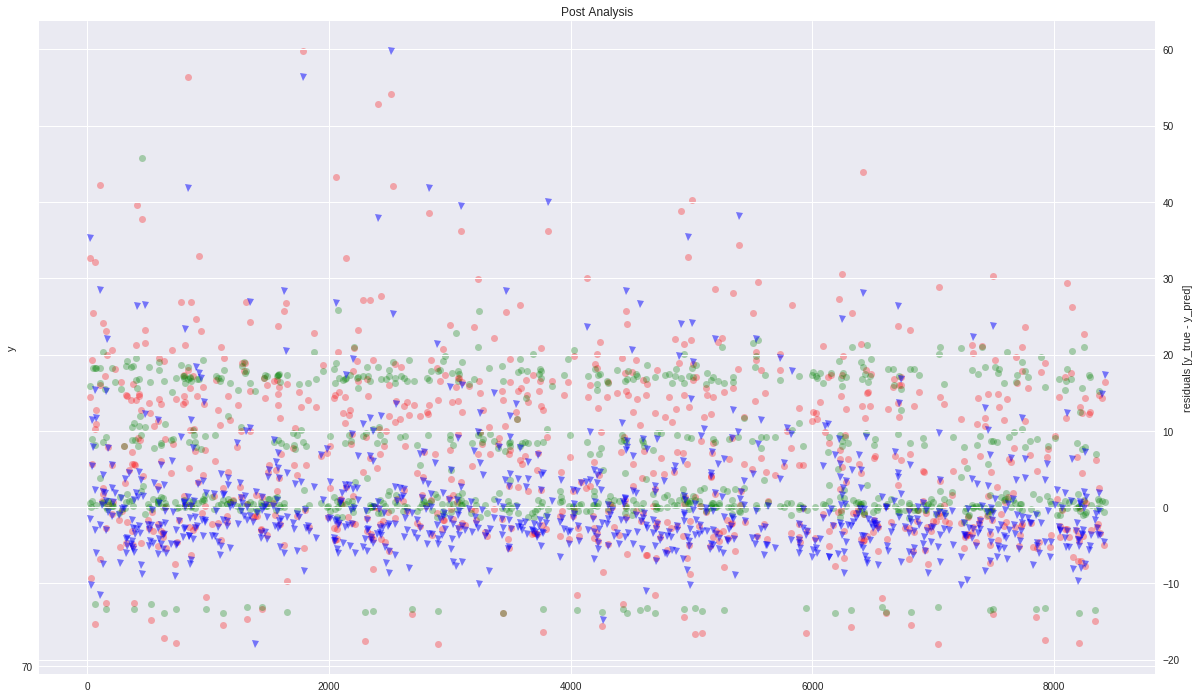

In [31]:
majorLocator = MultipleLocator(10)

fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
ax1.yaxis.set_major_locator(majorLocator)
ax2.yaxis.set_major_locator(majorLocator)
plt.show()

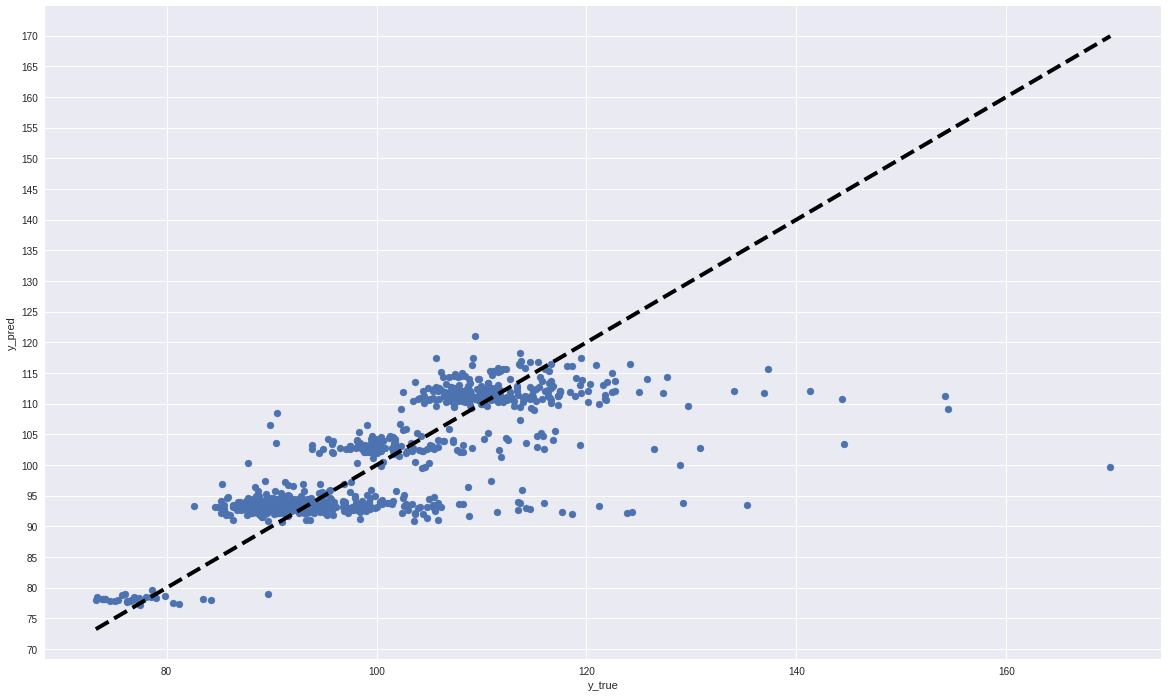

In [24]:
majorLocator = MultipleLocator(5)
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter( post_analysis['y_true'],  post_analysis['y_pred'])
ax.plot([ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 
        [ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 'k--', lw=4)
ax.yaxis.set_major_locator(majorLocator)
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')
plt.show()

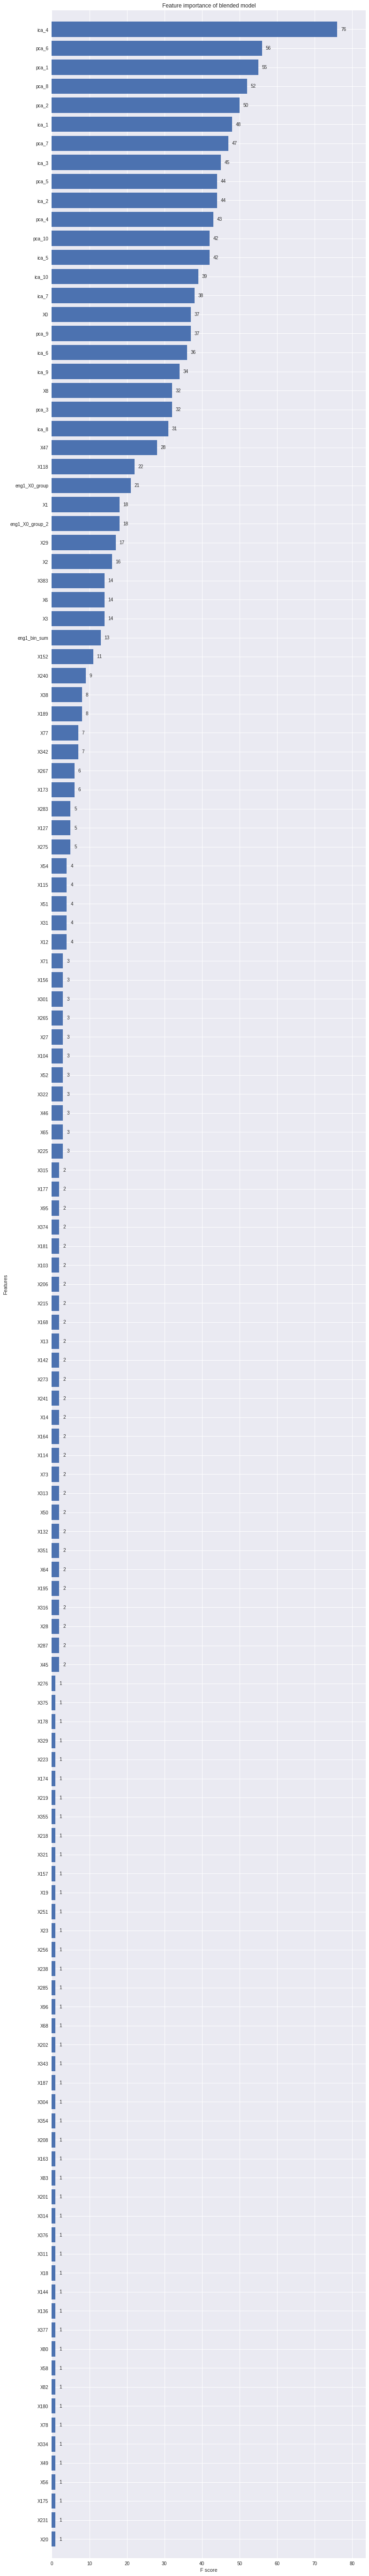

In [25]:
fig, ax = plt.subplots(figsize=(12,100))

xgb.plot_importance(model, height=0.8, ax=ax, title='Feature importance of blended model')

### Submission

In [26]:
def generate_submission_file(output_path, test_x, model, team_name):
    test_x['y'] = model.predict(test_x)
    test_x = test_x.reset_index()
    test_x = test_x[['ID', 'y']]
    
    # Preparing to output
    timestamp = str(int(time.time()))
    filename = output_path + '/submission-' + team_name + '-' + timestamp + ".csv"
    test_x.to_csv(filename, index=False)
    print('output filename:', filename)

In [27]:
team_name = 'jsardinha'
generate_submission_file(SUBMISSION_PATH, test_x, model, team_name)

output filename: /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-jsardinha-1498022268.csv
